In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import seaborn as sns
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly

import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode()
%matplotlib inline

In [3]:
import os
os.listdir(r"C:\Users\fpg_1\Documents\bike_preds\data")

['day.csv', 'hour.csv']

In [4]:
os.chdir(r'C:\Users\fpg_1\Documents\bike_preds')

In [5]:
day = pd.read_csv('data/day.csv')

In [6]:
day['dteday'] = pd.to_datetime(day['dteday'])
day.head()

instant     dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1 2011-01-01       1   0     1        0        6           0   
1        2 2011-01-02       1   0     1        0        0           0   
2        3 2011-01-03       1   0     1        0        1           1   
3        4 2011-01-04       1   0     1        0        2           1   
4        5 2011-01-05       1   0     1        0        3           1   

   weathersit      temp     atemp       hum  windspeed  casual  registered  \
0           2  0.344167  0.363625  0.805833   0.160446     331         654   
1           2  0.363478  0.353739  0.696087   0.248539     131         670   
2           1  0.196364  0.189405  0.437273   0.248309     120        1229   
3           1  0.200000  0.212122  0.590435   0.160296     108        1454   
4           1  0.226957  0.229270  0.436957   0.186900      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600

In [7]:
season_enum = { 1:'spring', 2:'summer', 3:'fall', 4:'winter' }
   
day['season_name'] = day['season'].apply(lambda id: season_enum[id])

# Objectives
* Null values? 
    - None
* Does season impact cnt?
* season 
* yr 
* mnth 
* holiday 
* weekday 
* workingday 
* weathersit 
* atemp 
   - higher temperature has a effect on the number of people cycling
* hum 
* windspeed 
* casual

In [8]:
ProfileReport(day, title='Pandas Profiling Report')

In [9]:
day = day.drop(['temp'], axis=1)

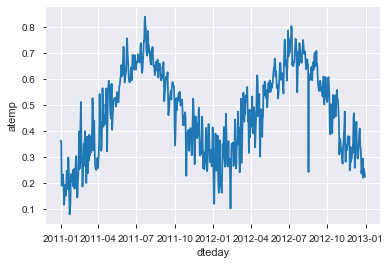

In [10]:
sns.lineplot(x='dteday', y='atemp', data=day)

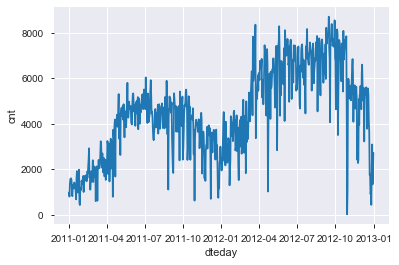

In [11]:
sns.lineplot(x='dteday', y='cnt', data=day)

### Does temperature affect count

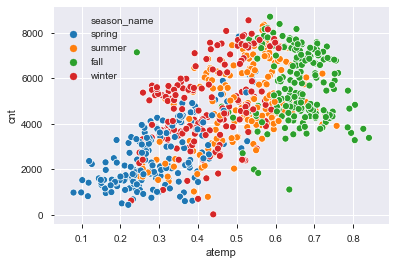

In [12]:
sns.scatterplot(x='atemp', y='cnt', hue='season_name', data=day)

### distributions of features
* every month does not have the same probability

In [13]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(8,8))
cols = ['season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'atemp', 'hum', 'windspeed',
       'casual', 'cnt']
for i, column in enumerate(cols):
    sns.distplot(day[column],ax=axes[i//3,i%3])
    axes[i//3,i%3].set_title(column)

### checking if month is set correctly in data - it is

In [14]:
day[day['dteday'].dt.month != day['mnth']]

Empty DataFrame
Columns: [instant, dteday, season, yr, mnth, holiday, weekday, workingday, weathersit, atemp, hum, windspeed, casual, registered, cnt, season_name]
Index: []

### Are season and atemp related

In [15]:
from functools import reduce
reduce(np.intersect1d, (day.groupby('season')['dteday'].unique()))

array([], dtype='datetime64[ns]')

In [16]:
day['dteday'].nunique()

731

In [17]:
day.groupby('season_name').aggregate({ 'atemp': ['mean', 'std', 'max', 'min']}).plot.bar()

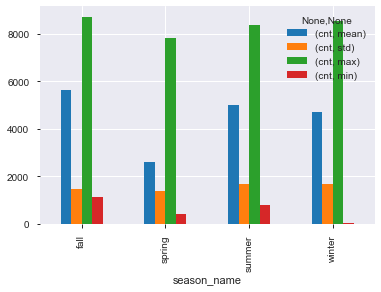

In [18]:
day.groupby('season_name').aggregate({ 'cnt': ['mean', 'std', 'max', 'min']}).plot.bar()

### weathersit: (extracted from Freemeteo)
* 1: Clear, Few clouds, Partly cloudy, Partly cloudy
* 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
* 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
* 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

In [19]:
day.groupby('weathersit').aggregate({ 'cnt': ['mean', 'std', 'max', 'min']}).plot.bar()

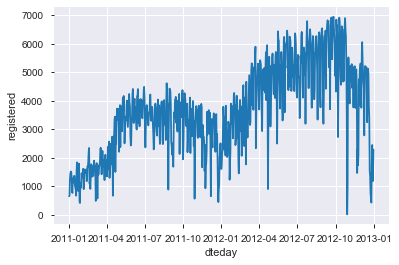

In [20]:
sns.lineplot(x='dteday', y='registered', data=day)

Adding dteday as a index of the hour dataframe

In [21]:
day.set_index('dteday', inplace=True)

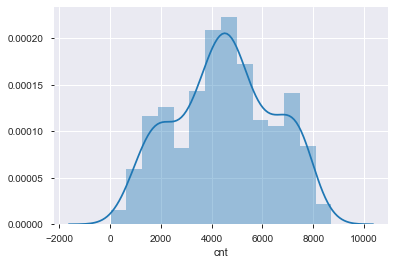

In [22]:
sns.distplot(day['cnt'])

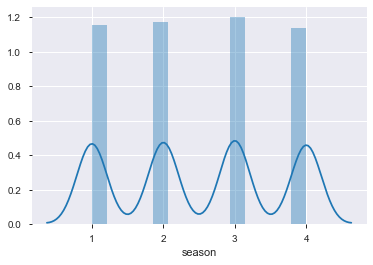

In [23]:
sns.distplot(day['season'])

<Figure size 432x288 with 0 Axes>

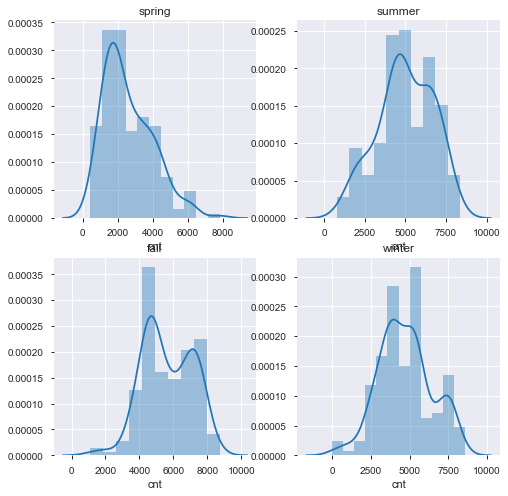

In [24]:
plt.figure();
fig, axs = plt.subplots(2,2, figsize=(8,8));
i = 1

seasons = day['season_name'].unique()

for n_ax in axs:
    for ax in n_ax:
        sns.distplot(day[day['season_name'] == seasons[i-1]]['cnt'], ax=ax)
        
        ax.set_title(seasons[i-1]);
        i+=1

In [25]:
from scipy.stats.mstats import kruskal

kruskal(
    day[day['season'] == 1]['cnt'].values,
    day[day['season'] == 2]['cnt'].values,
    day[day['season'] == 3]['cnt'].values,
    day[day['season'] == 4]['cnt'].values
)

# P value is greater than 0.05; failed to reject null hypo that distributions are same

# print('Statistics=%.3f, p=%.3f' % (stat, p))
# # interpret
# alpha = 0.05
# if pvalue > alpha:
#     print('Same distributions (fail to reject H0)')
# else:
#     print('Different distributions (reject H0)')

KruskalResult(statistic=250.9335046488973, pvalue=4.110755793069794e-54)

In [26]:
from scipy.stats import chi2_contingency

### Correlation between weathersit and season - cramers v (symmetrical) and theils eta (non symmetrical)

In [27]:
from dython.nominal import correlation_ratio, theils_u, associations

In [28]:
# associations(day[['season', 'weathersit']],theil_u=True)
theils_u(day['season'], day['weathersit']), theils_u(day['weathersit'], day['season'])

(0.007075822458043057, 0.012941362370961851)

In [29]:
theils_u(day['workingday'], day['weathersit']), theils_u(day['weathersit'], day['workingday'])

(0.003056392220938438, 0.002515830321765982)

high correaltion between season and atemp

In [30]:
correlation_ratio(day['season'], day['atemp']), correlation_ratio(day['atemp'], day['season'])

(0.8157116505272206, 0.9729429849206832)

In [31]:
day.columns

Index(['instant', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'atemp', 'hum', 'windspeed', 'casual', 'registered',
       'cnt', 'season_name'],
      dtype='object')

In [44]:
day_cleaned = day[['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt']]

In [33]:
nominal_columns = ['season', 'holiday', 'weekday', 'workingday',
       'weathersit']

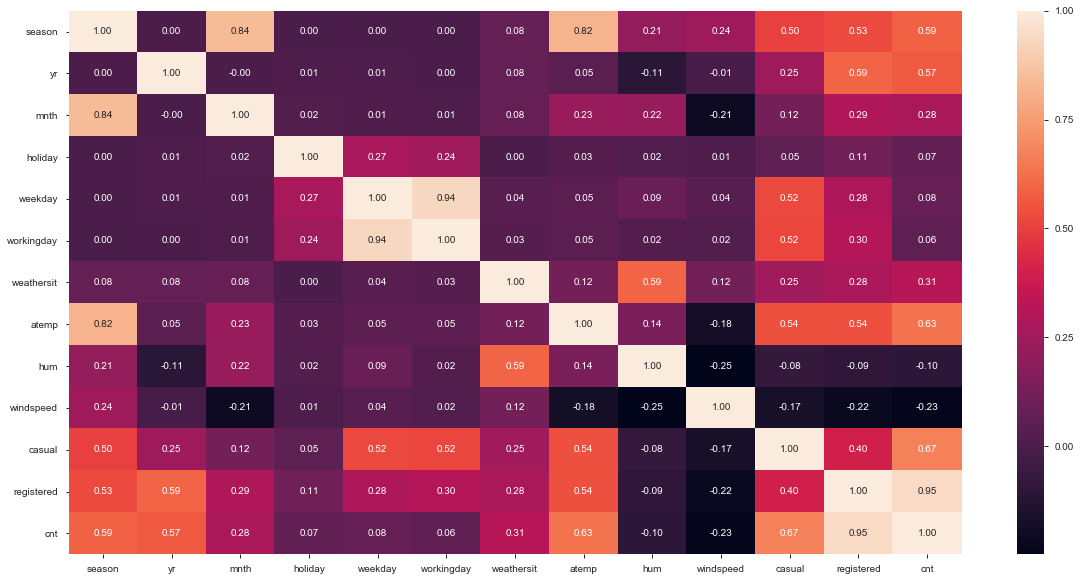

In [46]:
corr = associations(day_cleaned,theils_u=True,return_results=True, nominal_columns=nominal_columns, figsize=(20,10))

In [48]:
cor_target = abs(corr["cnt"])

#Selecting  features
relevant_features = cor_target[cor_target > 0.5]
relevant_features

season        0.589060
yr            0.566710
atemp         0.631066
casual        0.672804
registered    0.945517
cnt           1.000000
Name: cnt, dtype: float64

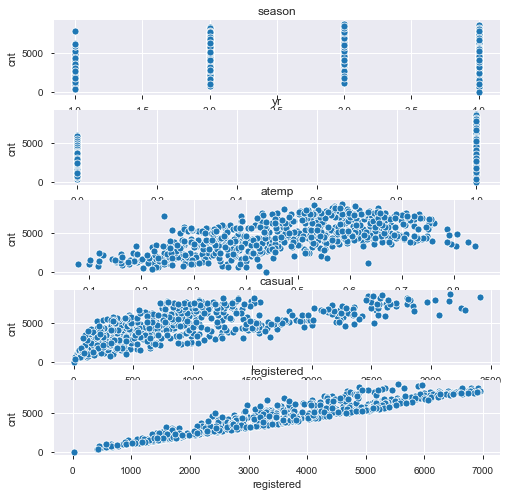

In [53]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8,8))

for i, column in enumerate(relevant_features.index[:-1]):
    sns.scatterplot(x=day[column], y=day['cnt'],data=day, ax=axes[i])
    axes[i].set_title(column)